In [1]:
import torch
import numpy as np
import time
import matplotlib
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='svg'
%matplotlib inline
from a2c.model import Policy
from microgrid import MG_for_test
env = MG_for_test(True,True)
actor_critic = Policy(
    env.observation_space.shape,
    env.action_space.shape,
    base_kwargs={'recurrent': True,'assign_credit':True})
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
actor_critic.to(device)

Policy(
  (base): Network(
    (gru): GRU(20, 128)
    (actor): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): Tanh()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): Tanh()
    )
    (mean): Sequential(
      (0): Linear(in_features=128, out_features=16, bias=True)
      (1): Sigmoid()
    )
    (std): Sequential(
      (0): Linear(in_features=128, out_features=16, bias=True)
      (1): Sigmoid()
    )
    (critic): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): Tanh()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): Tanh()
      (4): Linear(in_features=128, out_features=16, bias=True)
    )
  )
)

In [18]:
checkpoint_ours = torch.load('./models/multi_values/best')
actor_critic.base.load_state_dict(checkpoint_ours['model_state_dict'],strict=False)
actor_critic.base.eval()
EV_ours = np.zeros([12*24,5])
env.seed(1)
obs = env.reset()
EV_ours[0] = env.EVs_demand
recurrent_hidden_states = torch.zeros(1, actor_critic.recurrent_hidden_state_size, device=device)
mask = torch.zeros(1, 1, device=device)
done = False
i=1
while i<12*24:
    with torch.no_grad():
        _, action, recurrent_hidden_states = actor_critic.act(
            torch.tensor(env.obs_scalar(obs),dtype=torch.float).unsqueeze(0).to(device), recurrent_hidden_states, mask)
    # Obser reward and next obs
    obs, cost, done, info = env.move(action.detach().cpu().numpy()[0])
    EV_ours[i] = env.EVs_demand
    i+=1
    eval_masks = torch.tensor(
        [[0.0] if done else [1.0]],
        dtype=torch.float,
        device=device)

In [19]:
checkpoint4 = torch.load('./models/user_first/best')
actor_critic.base.load_state_dict(checkpoint4['model_state_dict'],strict=False)
actor_critic.base.eval()
observations = np.zeros([12*24,env.observation_space.shape[0]])
EV4 = np.zeros([12*24,5])
env.seed(1)
obs = env.reset()
EV4[0] = env.EVs_demand
recurrent_hidden_states = torch.zeros(1, actor_critic.recurrent_hidden_state_size, device=device)
mask = torch.zeros(1, 1, device=device)
done = False
i=1
while i<12*24:
    with torch.no_grad():
        _, action, recurrent_hidden_states = actor_critic.act(
            torch.tensor(env.obs_scalar(obs),dtype=torch.float).unsqueeze(0).to(device), recurrent_hidden_states, mask)
    # Obser reward and next obs
    obs, cost, done, info = env.move(action.detach().cpu().numpy()[0])
    observations[i] = obs
    EV4[i] = env.EVs_demand
    i+=1
    eval_masks = torch.tensor(
        [[0.0] if done else [1.0]],
        dtype=torch.float,
        device=device)

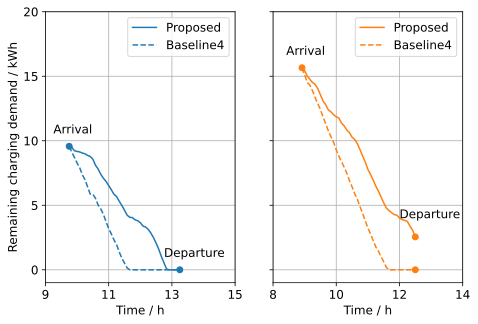

In [107]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(7.5, 5))

start = int(env.EVs_start[3])
end = int(env.EVs_end[3])+1
t = observations[start:end,0]
ax1.plot(t,EV_ours[start:end,3],'C0',label='Proposed')
ax1.plot(t,EV4[start:end,3],'C0--',label='Baseline4')
ax1.plot(observations[start,0], env.EVs_required[3],'C0o')
ax1.text(observations[start,0]-0.5, env.EVs_required[3]+1,'Arrival',fontsize=12)
ax1.plot(observations[end-1,0], 0,'C0o')
ax1.text(observations[end-1,0]-0.5, 1,'Departure',fontsize=12)
ax1.tick_params(axis="x", labelsize=12)
ax1.tick_params(axis="y", labelsize=12)
ax1.set_yticks(np.linspace(0,20,5))
ax1.set_xticks(np.linspace(9,15,4))
ax1.set_ylim(-1,20)
ax1.set_xlim(9,15)
ax1.set_xlabel('Time / h',fontsize=12)
ax1.set_ylabel('Remaining charging demand / kWh',fontsize=12)
ax1.grid()
ax1.legend(fontsize=12)

start = int(env.EVs_start[2])
end = int(env.EVs_end[2])+1
t = observations[start:end,0]
ax2.plot(t,EV_ours[start:end,2],'C1',label='Proposed')
ax2.plot(t,EV4[start:end,2],'C1--',label='Baseline4')
ax2.plot(observations[start,0], env.EVs_required[2],'C1o')
ax2.text(observations[start,0]-0.5, env.EVs_required[2]+1,'Arrival',fontsize=12)
ax2.plot(observations[end-1,0], 0,'C1o')
ax2.plot(observations[end-1,0], EV_ours[end-1,2],'C1o')
ax2.text(observations[end-1,0]-0.5, 4,'Departure',fontsize=12)
ax2.tick_params(axis="x", labelsize=12)
ax2.tick_params(axis="y", labelsize=12)
ax2.set_yticks(np.linspace(0,20,5))
ax2.set_xticks(np.linspace(8,14,4))
ax2.set_ylim(-1,20)
ax2.set_xlim(8,14)
ax2.set_xlabel('Time / h',fontsize=12)
#ax2.set_ylabel('Remaining charging demand / kWh')
ax2.grid()
ax2.legend(fontsize=12)
fig.savefig(fname='./figure/EV.svg',format='svg',bbox_inches = 'tight', pad_inches = 0)
fig.show()

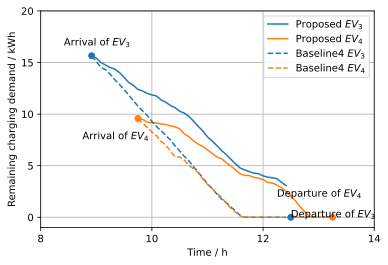

In [41]:
#plt.plot(observations[:-1,0],observations[:-1,4])
plt.plot(observations[int(env.EVs_start[2]):int(env.EVs_end[2]),0],EV_ours[int(env.EVs_start[2]):int(env.EVs_end[2]),2],'C0',label='Proposed $EV_3$')
plt.plot(observations[int(env.EVs_start[3]):int(env.EVs_end[3]),0],EV_ours[int(env.EVs_start[3]):int(env.EVs_end[3]),3],'C1',label='Proposed $EV_4$')
plt.plot(observations[int(env.EVs_start[2]):int(env.EVs_end[2]),0],EV4[int(env.EVs_start[2]):int(env.EVs_end[2]),2],'C0--',label='Baseline4 $EV_3$')
plt.plot(observations[int(env.EVs_start[3]):int(env.EVs_end[3]),0],EV4[int(env.EVs_start[3]):int(env.EVs_end[3]),3],'C1--',label='Baseline4 $EV_4$')
plt.plot(observations[int(env.EVs_start[2]),0], env.EVs_required[2],'C0o')
plt.text(observations[int(env.EVs_start[2]),0]-0.5, env.EVs_required[2]+1,'Arrival of $EV_3$')
plt.plot(observations[int(env.EVs_start[3]),0], env.EVs_required[3],'C1o')
plt.text(observations[int(env.EVs_start[3]),0]-1, env.EVs_required[3]-2,'Arrival of $EV_4$')

plt.plot(observations[int(env.EVs_end[2]),0], 0,'C0o')
plt.text(observations[int(env.EVs_end[2]),0], 0,'Departure of $EV_3$')
plt.plot(observations[int(env.EVs_end[3]),0], 0,'C1o')
plt.text(observations[int(env.EVs_end[3]),0]-1, 2,'Departure of $EV_4$')
plt.yticks(np.linspace(0,20,5))
plt.xticks(np.linspace(8,14,4))
plt.ylim(-1,20)
plt.xlim(8,14)
plt.xlabel('Time / h')
plt.ylabel('Remaining charging demand / kWh')
plt.plot()
plt.legend()
plt.grid()
#plt.savefig(fname='./figure/soc.svg',format='svg')
plt.show()

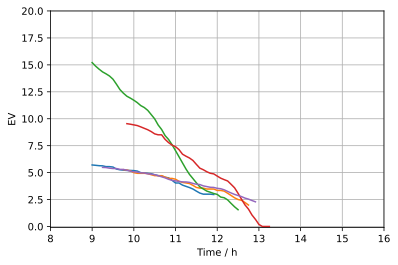

In [5]:
#plt.plot(observations[:-1,0],observations[:-1,4])
for i in range(5):
    plt.plot(observations[int(env.EVs_start[i]):int(env.EVs_end[i]),0],EV_ours[int(env.EVs_start[i]):int(env.EVs_end[i]),i])
plt.ylim(-0.1,20)
plt.xlim(8,16)
plt.xlabel('Time / h')
plt.ylabel('EV')
plt.plot()
#plt.xticks(np.linspace(0,24,7))
plt.grid()
#plt.savefig(fname='./figure/soc.svg',format='svg')
plt.show()